In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpim

In [44]:
ballpose = [0, 0]
padlpose = [0, 0]
gameframe = np.zeros([26, 37])

def paddle():
    if ballpose[1] < padlpose[1]:
        return -1
    elif ballpose[1] > padlpose[1]:
        return 1
    else:
        return 0
    
def drawframe(outbuf, framecount, draw=False, save=True):
    frame = np.zeros(26, 37)
    i = 0
    while i < len(outbuf):
        frame[outbuf[i+1], outbuf[i]] = outbuf[i+2]
        i += 3
    if draw:
        plt.imshow(frame, cmap='jet')
    if save:
        mpim.imsave('frame{:05d}.png'.format(framecount), frame)

def resolve_arg(program, argmode, base_offset, i, j):
    if argmode == 0:
        return program[i+j]
    elif argmode == 1:
        return i+j
    elif argmode == 2:
        return base_offset + program[i+j]

    
def intcode(program, inlist=[], i=0):
    outbuf = []
    base_offset = 0
    global ballpose
    global padlpose
    global gameframe
    framecount = 0
    score = 0
    
    while True:
        if i >= len(program):
            print('end of program')
            return program
        opcode = program[i]
        
#         print(i, opcode, base_offset)
        
        op = opcode % 100
        argmodes = []
        argcode = opcode // 100
        while argcode > 0:
            argmodes.append(argcode % 10)
            argcode = argcode // 10
            
        # ADD A B -> C
        # --------------------------------------------------------
        if op == 1:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)
            
            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)

            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]                
            
            program[idx3] = arg1 + arg2
            i += 4
        # MULTIPLY A B ->
        # --------------------------------------------------------
        elif op == 2:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)

            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)
                
            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]
            
            program[idx3] = arg1 * arg2
            i += 4
        # INPUT -> A
        # --------------------------------------------------------
        elif op == 3:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            
            if len(program) <= idx:
                program += [0]*(idx - len(program) + 1)

            if len(inlist) > 0:
                program[idx] = inlist[0]
                inlist = inlist[1:]
            else:
                program[idx] = paddle()
            i += 2
        # OUTPUT A
        # --------------------------------------------------------
        elif op == 4:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            outbuf.append(program[idx])
            
            if len(outbuf) == 3:
                if outbuf[0] == -1 and outbuf[1] == 0:
                    score = outbuf[2]
                else:
                    gameframe[outbuf[1], outbuf[0]] = outbuf[2]
                    if outbuf[2] == 3:
                        padlpose = [outbuf[1], outbuf[0]]
                        mpim.imsave('calca_13_frames/frame{:05d}.png'.format(framecount), 
                                    gameframe/gameframe.max())
                        framecount += 1
                    elif outbuf[2] == 4:
                        ballpose = [outbuf[1], outbuf[0]]
                outbuf = []
                        
            i += 2
        # JUMP TRUE A != 0 -> B
        # --------------------------------------------------------
        elif op == 5:                
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx1 = resolve_arg(program, argmode, base_offset, i, 1)
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx2 = resolve_arg(program, argmode, base_offset, i, 2)
            
            bigdex = max([idx1, idx2])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
            
            arg1 = program[idx1]
            arg2 = program[idx2]    
            if arg1 != 0:
                i = arg2
            else:
                i += 3
        # JUMP FALSE A == 0 -> B
        # --------------------------------------------------------
        elif op == 6:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            if len(program) <= arg2:
                program += [0]*(arg2-len(program)+1)
                
            if arg1 == 0:
                i = arg2
            else:
                i += 3
        # LESS THAN A < B 1 -> C
        # --------------------------------------------------------
        elif op == 7:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 < arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # EQUALS A == B 1 -> C
        # --------------------------------------------------------
        elif op == 8:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
#             arg3 = program[idx]
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 == arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # SHIFT RELATIVE BASE
        # --------------------------------------------------------
        elif op == 9:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            base_offset += arg1
            if len(program) <= base_offset:
                program += [0]*(base_offset-len(program)+1)
            i += 2
        # HALT
        # --------------------------------------------------------
        elif op == 99:
            print(score)
            return outbuf
        # INVALID
        # --------------------------------------------------------
        else:
            print(program[i], 'is not an instruction')
            return outbuf

In [45]:
with open('calca_13_input.txt', 'r') as infile:
    program = [[int(c) for c in r.split(',')] for r in infile][0]
    print(program[0])
    
program[0] = 2
outbuf = intcode(program)

1
19297


25 36
there are 372 blocks


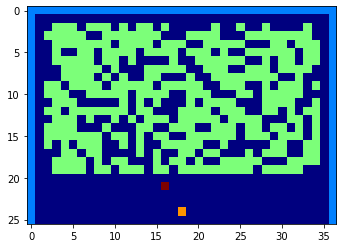

In [31]:
with open('calca_13_input.txt', 'r') as infile:
    program = [[int(c) for c in r.split(',')] for r in infile][0]
    
outbuf = intcode(program)
drawlist = []
i = 0
maxx = 0
maxy = 0
blockcount = 0
while i < len(outbuf):
    drawitem = [outbuf[i], outbuf[i+1], outbuf[i+2]]
    drawlist.append(drawitem)
    
    if outbuf[i+1] > maxx:
        maxx = outbuf[i+1]
    if outbuf[i] > maxy:
        maxy = outbuf[i]
    if outbuf[i+2] == 2:
        blockcount += 1
        
    i += 3
print(maxx, maxy)
        
print('there are {} blocks'.format(blockcount))

frame = np.zeros([maxx+1, maxy+1])
for item in drawlist:
    frame[item[1], item[0]] = item[2]
    
frame = 255*frame/frame.max()
plt.imshow(frame, cmap='jet')
mpim.imsave('calca_13_frames/frame.png', frame)

In [36]:
with open('calca_13_input.txt', 'r') as infile:
    program = [[int(c) for c in r.split(',')] for r in infile][0]
    
outbuf = intcode(program)

0


In [43]:
program[0]

2